<a href="https://colab.research.google.com/github/suvankit/Speech-emotion-recognition/blob/main/SER_Minor_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras

In [ ]:
Ravdess="/content/gdrive/MyDrive/archive/Ravdess/audio_speech_actors_01-24/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...
1     calm  /content/gdrive/MyDrive/archive/Ravdess/audio_...
2      sad  /content/gdrive/MyDrive/archive/Ravdess/audio_...
3    happy  /content/gdrive/MyDrive/archive/Ravdess/audio_...
4    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...

In [ ]:
data_path4 = pd.concat([Ravdess_df], axis = 0)
data_path4.to_csv("data_path4.csv",index=False)
data_path4.head()

Emotions                                               Path
0    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...
1     calm  /content/gdrive/MyDrive/archive/Ravdess/audio_...
2      sad  /content/gdrive/MyDrive/archive/Ravdess/audio_...
3    happy  /content/gdrive/MyDrive/archive/Ravdess/audio_...
4    angry  /content/gdrive/MyDrive/archive/Ravdess/audio_...

# Spectogram

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


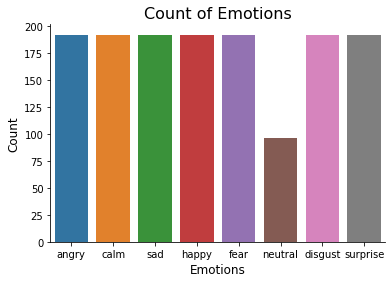

In [ ]:
#count of each emotions
plt.title('Count of Emotions', size=16)
sns.countplot(data_path4.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
import torch
import torchaudio
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook
def load_mono(audio_path):
  wave, sr = librosa.load(audio_path,sr=None,mono=True)
  
  # trim silent edges
  wave, _ = librosa.effects.trim(wave)

  # convert to tensor
  wave = torch.FloatTensor(wave).unsqueeze(0)
  return wave, sr

In [ ]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
def show_audio(audio_path):
  y, sr = librosa.load(audio_path, sr=None,mono=True)
  print(f"Sample rate : {sr}")
  
  # trim silent edges
  audio, _ = librosa.effects.trim(y)
  
  fig = plt.figure(figsize=(20,15))
  n_fft = 2048
  hop_length = 256
  n_mels = 128

  plt.subplot(3,3,1)
  librosa.display.waveplot(audio, sr=sr);
  plt.title('1. raw wave form data');

  plt.subplot(3,3,2)
  D = np.abs(librosa.stft(audio[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
  plt.plot(D);
  plt.title(f'2. fourier transform of a window(length={n_fft})');

  plt.subplot(3,3,3)
  D = np.abs(librosa.stft(audio, n_fft=n_fft,  hop_length=hop_length))
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
  plt.colorbar();
  plt.title('3. applyed the Fourier Transform');

  plt.subplot(3,3,4)
  DB = librosa.amplitude_to_db(D, ref=np.max)
  librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
  plt.colorbar(format='%+2.0f dB');
  plt.title('4. Spectrogram');

  mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
  
  plt.subplot(3,3,5);
  librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
  plt.ylabel('Mel filter');
  plt.colorbar();
  plt.title('5. Our filter bank for converting from Hz to mels.');

  plt.subplot(3, 3, 6);
  mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
  librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
  plt.ylabel('Mel filter');
  plt.colorbar();
  plt.title('6. Easier to see what is happening with only 10 mels.');

  plt.subplot(3, 3, 7);
  idxs_to_plot = range(0,127,10)
  for i in idxs_to_plot:
      plt.plot(mel[i]);
  plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
  plt.title('6. Plotting some of the triangular filters from the mels');

  plt.subplot(3,3,8)
  plt.plot(D[:, 1]);
  plt.plot(mel.dot(D[:, 1]));
  plt.legend(labels=['Hz', 'mel']);
  plt.title('8. One sampled window for example, before and after converting to mel.');

  plt.subplot(3,3,9)
  S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  S_DB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2.0f dB');
  plt.title('9. Mel - Spectrogram');

  fig.tight_layout() 
  plt.show()

## Happy

happy
Sample rate : 48000


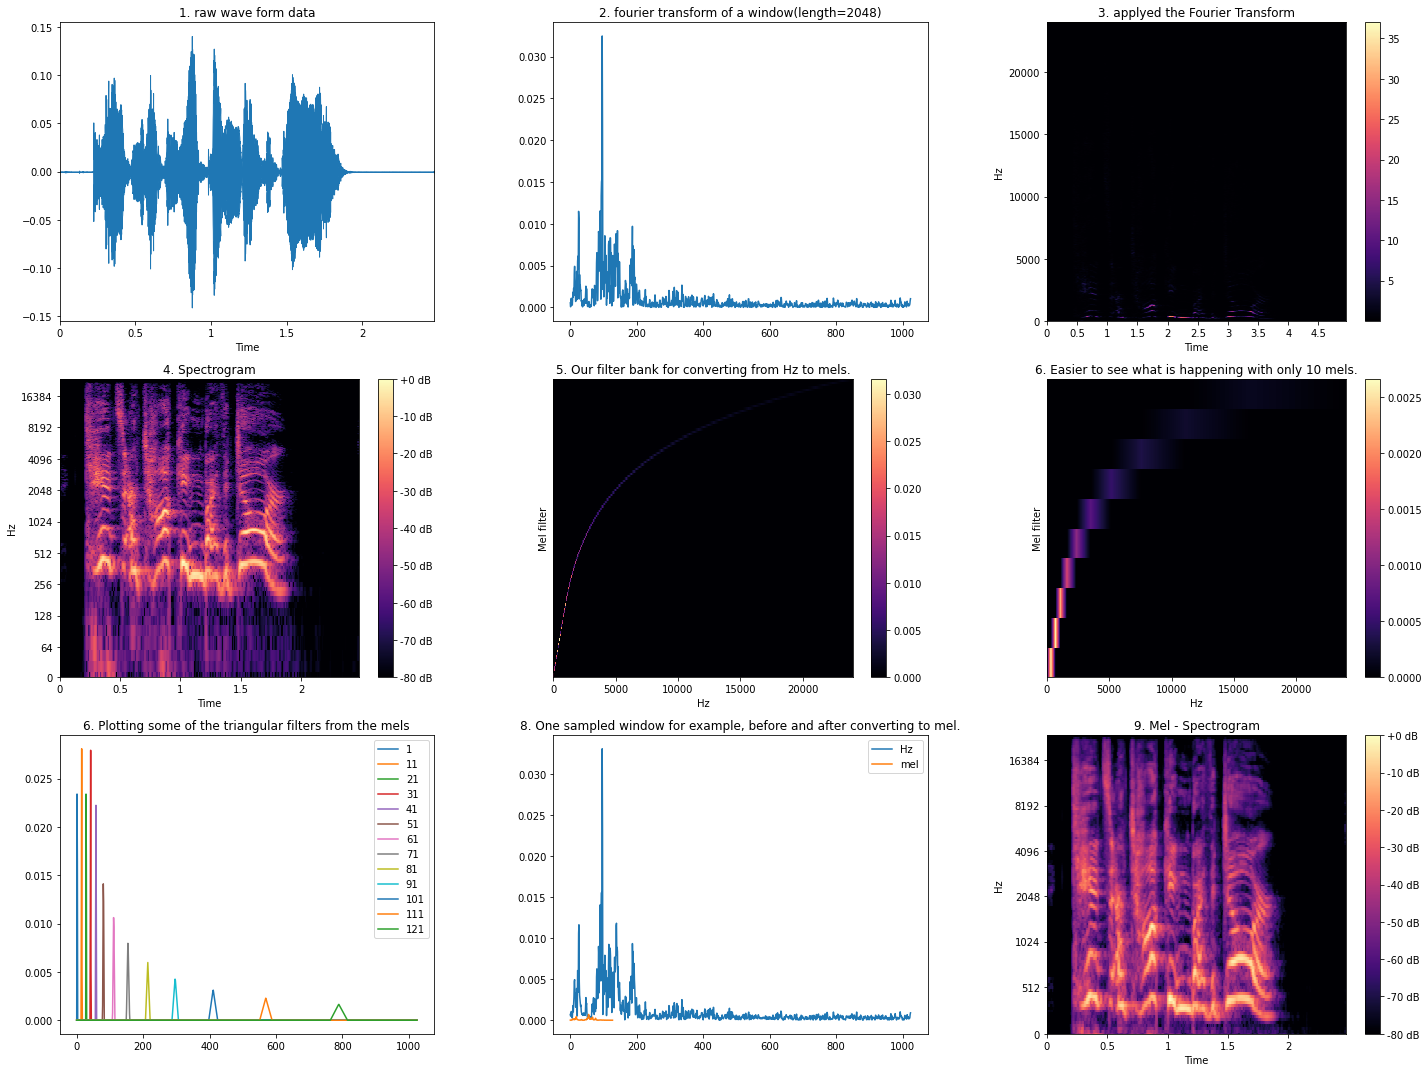

In [ ]:
i = 606
path = data_path4["Path"].iloc[i]
print(data_path4.iloc[i]["Emotions"])
show_audio(path)

# Lets play the audio 
data, rate = load_mono(path)
ipd.Audio(data=data.numpy(),rate=rate)

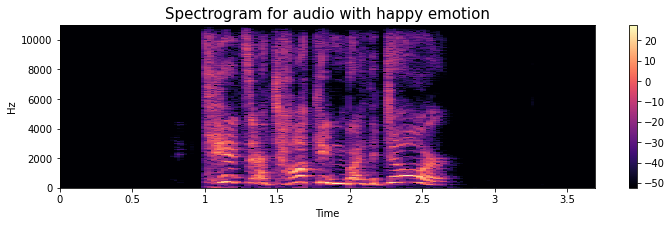

In [ ]:
i = 606
path = data_path4["Path"].iloc[i]
data, sampling_rate = librosa.load(path)
#emotion=print(data_path4.iloc[i]["Emotions"])
emotion='happy'
#create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Sad

sad
Sample rate : 48000


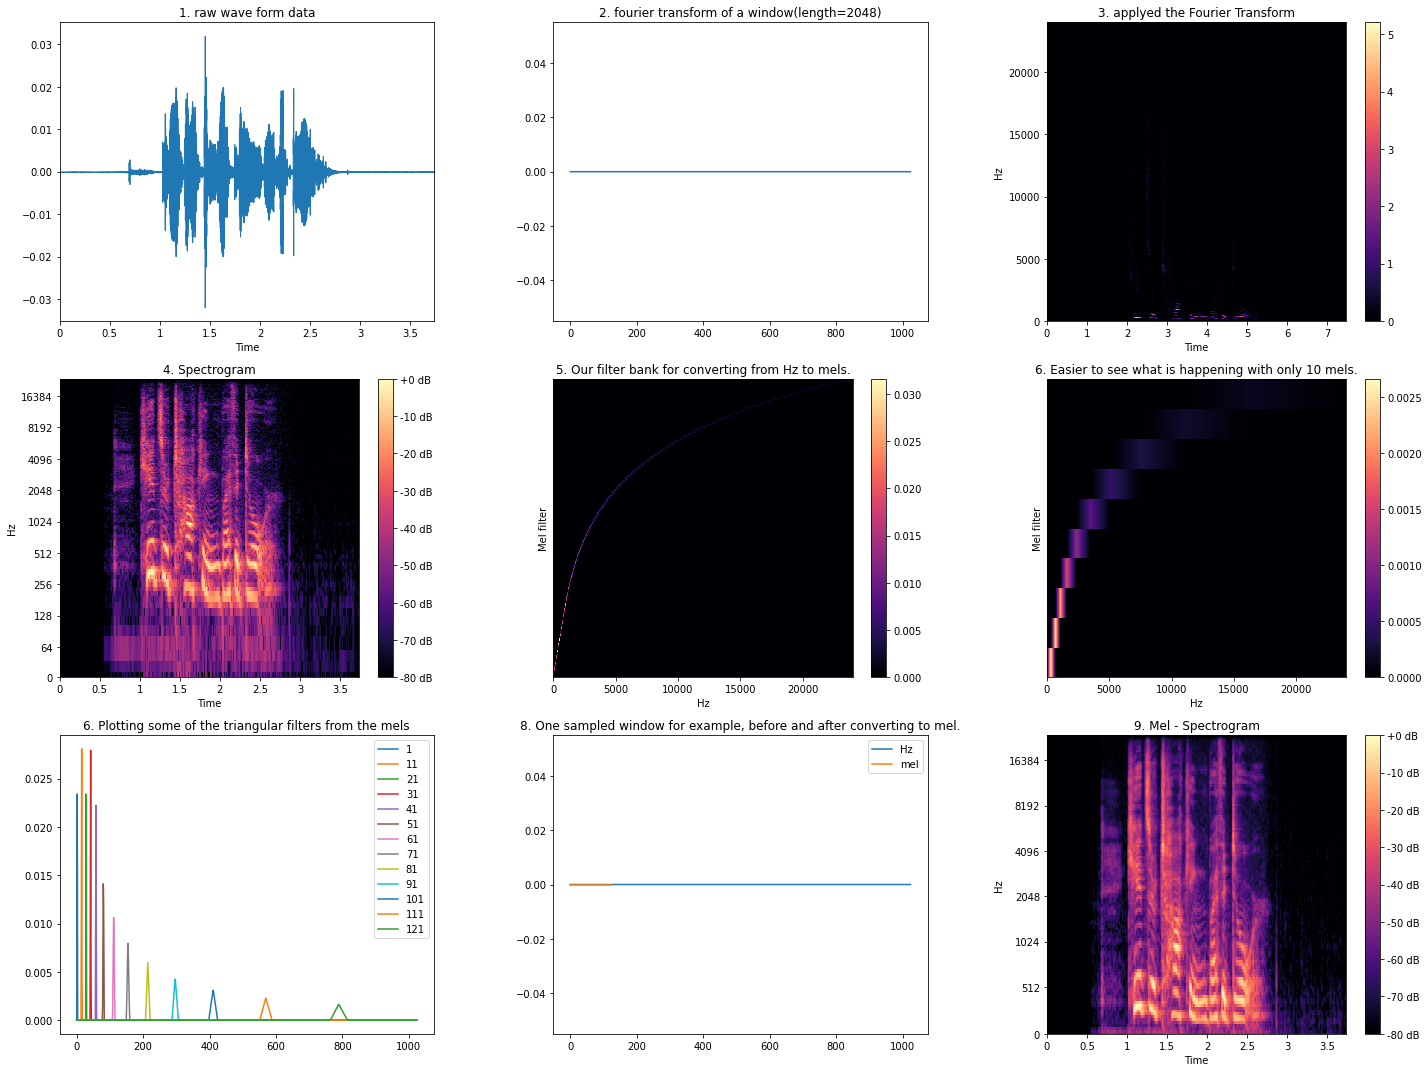

In [ ]:
i = 605
path = data_path4["Path"].iloc[i]
print(data_path4.iloc[i]["Emotions"])
show_audio(path)

# Lets play the audio 
data, rate = load_mono(path)
ipd.Audio(data=data.numpy(),rate=rate)

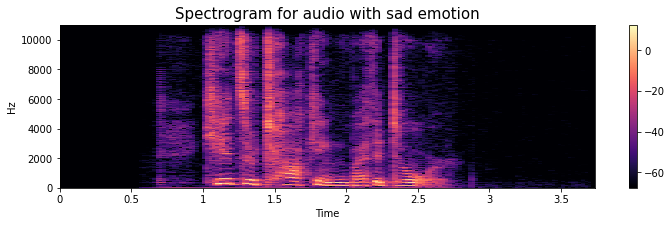

In [ ]:
# emotion='sad'
# path = np.array(data_path4.Path[data_path4.Emotions==emotion])[1]
i = 605
path = data_path4["Path"].iloc[i]
data, sampling_rate = librosa.load(path)

#create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Neutral

neutral
Sample rate : 48000


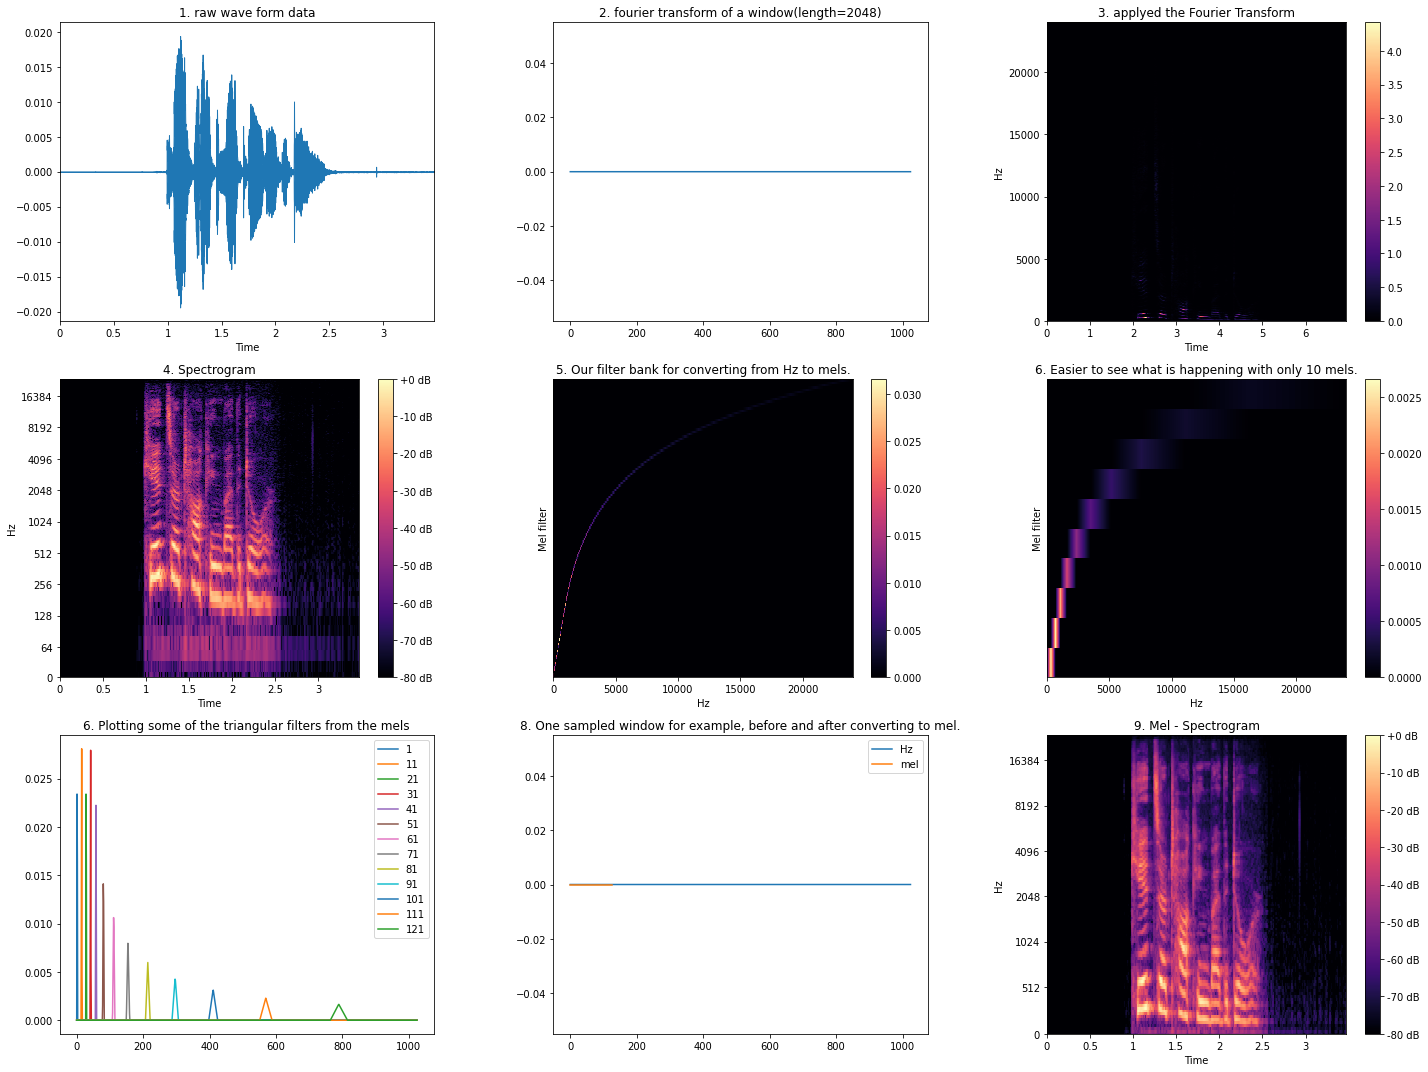

In [ ]:
i = 601
path = data_path4["Path"].iloc[i]
print(data_path4.iloc[i]["Emotions"])
show_audio(path)

# Lets play the audio 
data, rate = load_mono(path)
ipd.Audio(data=data.numpy(),rate=rate)

## Angry

angry
Sample rate : 48000


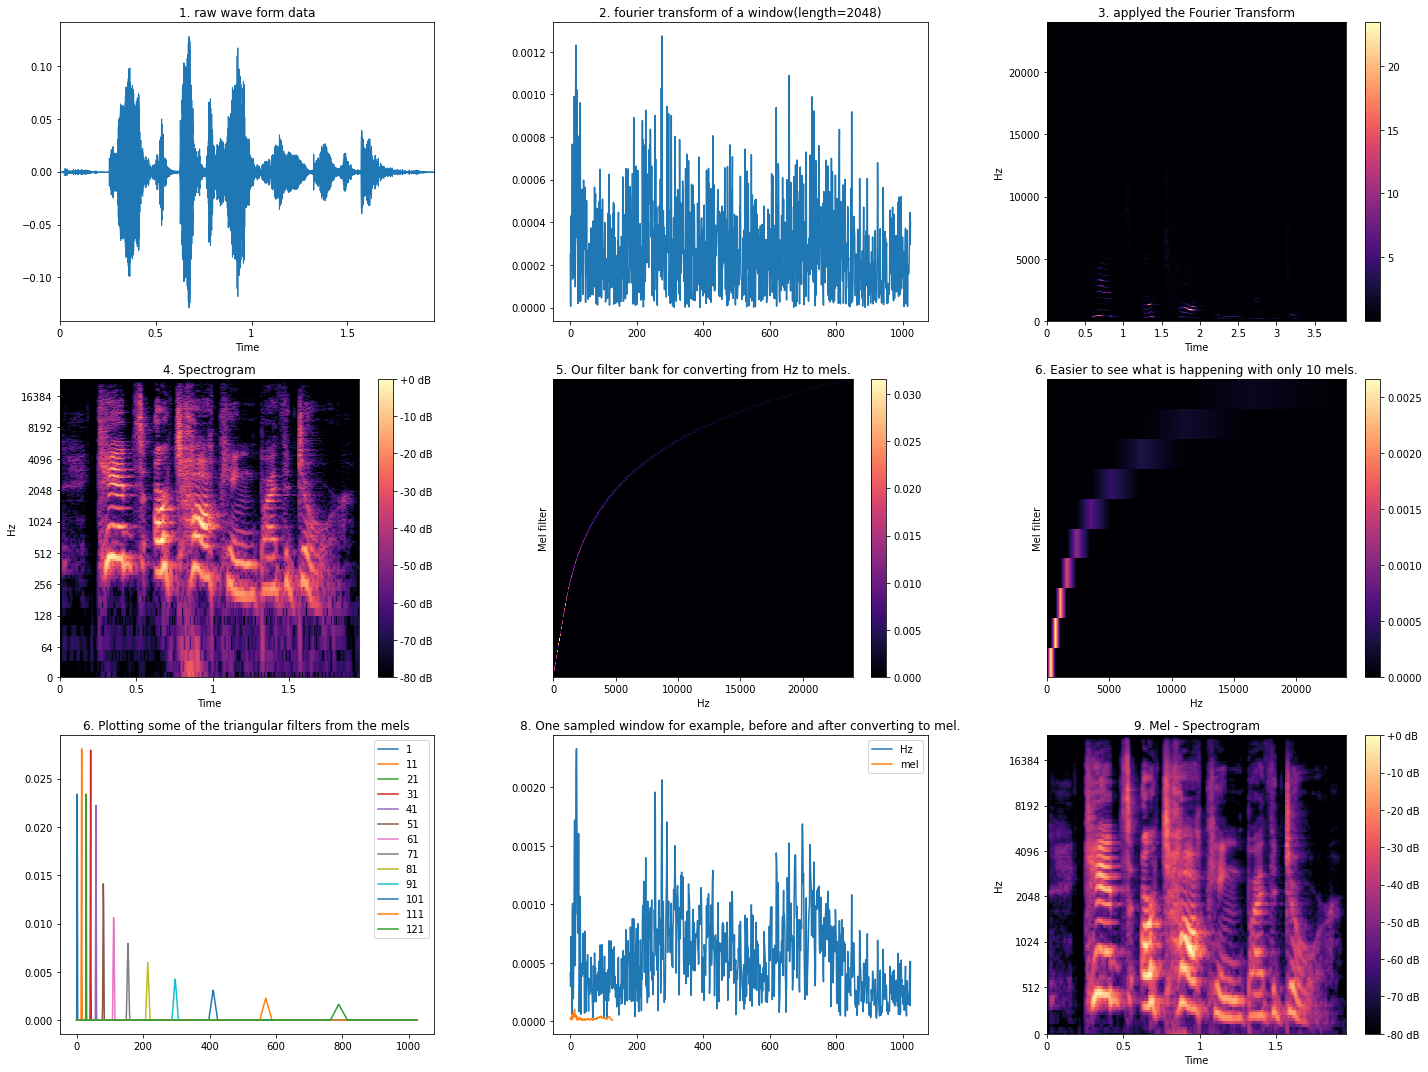

In [ ]:
i = 609
path = data_path4["Path"].iloc[i]
print(data_path4.iloc[i]["Emotions"])
show_audio(path)

# Lets play the audio 
data, rate = load_mono(path)
ipd.Audio(data=data.numpy(),rate=rate)

# MFCC

## Happy

In [ ]:
#happy
i = 606
audio_file = data_path4["Path"].iloc[i]

In [ ]:
# load audio files with librosa
signal, sr = librosa.load(audio_file)

In [ ]:
#EXtracting MFCC
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)

In [ ]:
mfccs

array([[-724.7233, -724.7233, -724.7233, ..., -724.7233, -724.7233,
        -724.7233],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)

In [ ]:
mfccs.shape

(13, 159)

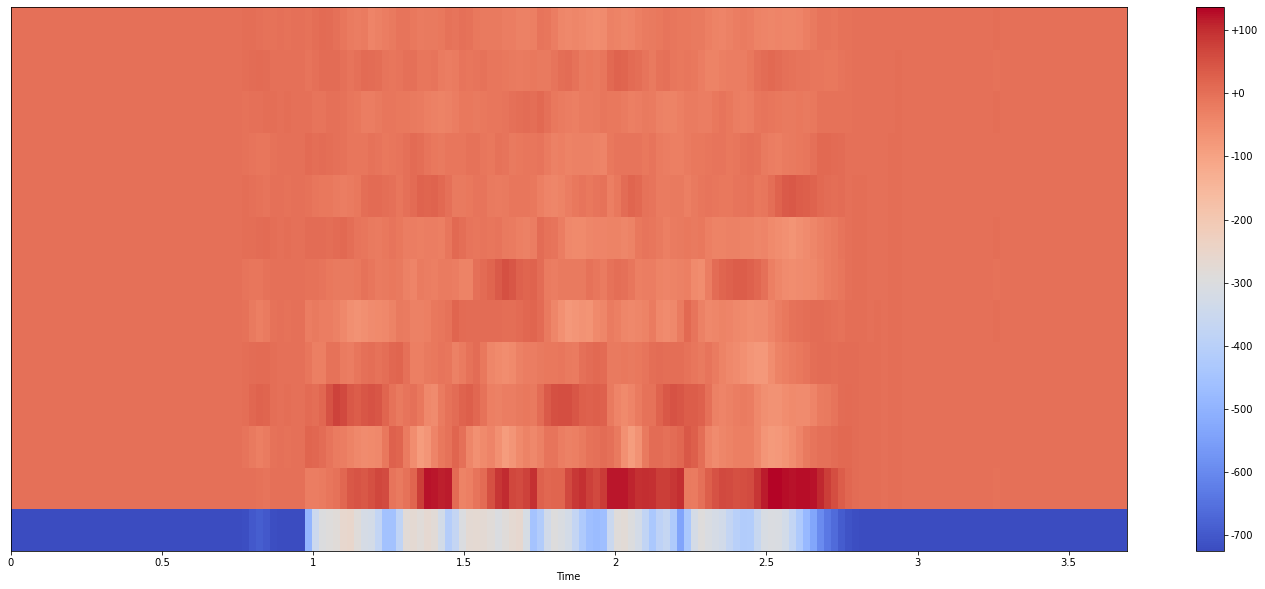

In [ ]:
#visualising MFCCs
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()
# x axis we have time and y axis we have mfccs coefficients

In [ ]:
#computing first and second MFCCs derivatives
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [ ]:
delta_mfccs

array([[6.1580667e-15, 6.1580667e-15, 6.1580667e-15, ..., 6.1580667e-15,
        6.1580667e-15, 6.1580667e-15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
delta_mfccs.shape

(13, 159)

In [ ]:
delta2_mfccs

array([[3.2676295e-14, 3.2676295e-14, 3.2676295e-14, ..., 3.2676295e-14,
        3.2676295e-14, 3.2676295e-14],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

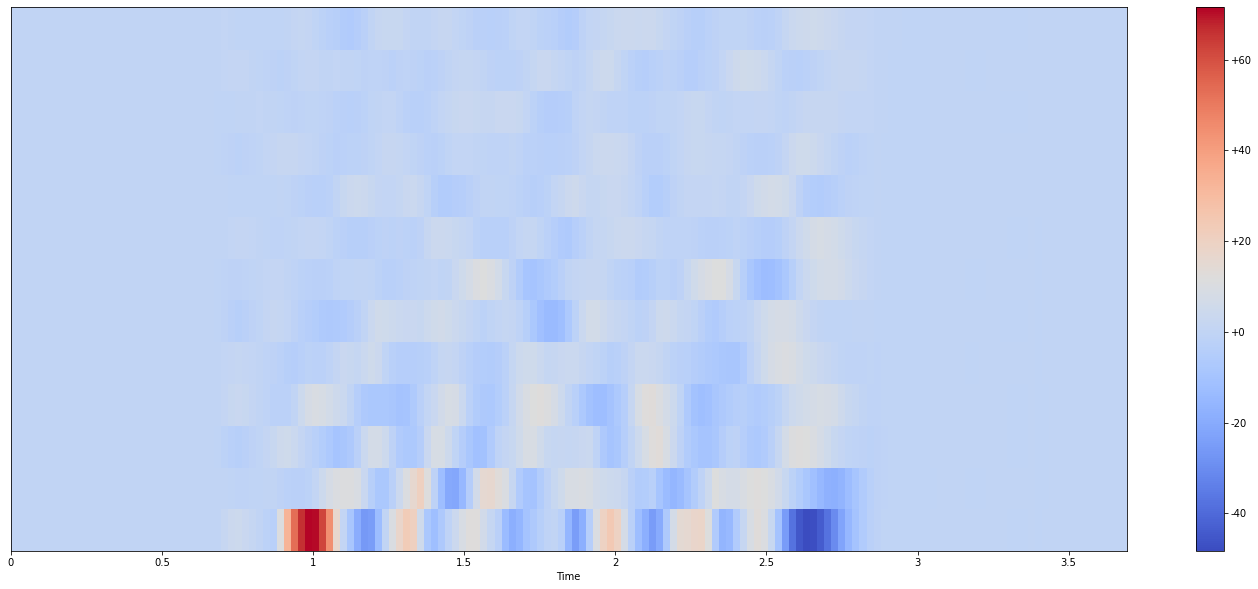

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
mfccs_features.shape

(39, 159)

In [ ]:
mfccs_features

array([[-724.7233, -724.7233, -724.7233, ..., -724.7233, -724.7233,
        -724.7233],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)

## Sad

In [ ]:
i = 605
audio_file = data_path4["Path"].iloc[i]

In [ ]:
signal, sr = librosa.load(audio_file)

In [ ]:
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [ ]:
mfccs

array([[-9.0732660e+02, -9.0732660e+02, -9.0732660e+02, ...,
        -8.8616980e+02, -8.9628424e+02, -9.0323151e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.6590963e+01,  1.4726548e+01,  5.3666277e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.0839603e+01,  1.2623119e+01,  4.3923097e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -9.4941396e-01, -8.1174922e-01, -1.4059424e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.2478784e+00, -5.8734000e-01, -1.6096188e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.1496897e+00, -3.1199574e-02, -1.3685451e+00]], dtype=float32)

In [ ]:
mfccs.shape

(13, 161)

In [ ]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
mfccs_features.shape

(39, 161)

In [ ]:
mfccs_features

array([[-9.0732660e+02, -9.0732660e+02, -9.0732660e+02, ...,
        -8.8616980e+02, -8.9628424e+02, -9.0323151e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.6590963e+01,  1.4726548e+01,  5.3666277e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.0839603e+01,  1.2623119e+01,  4.3923097e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.6843748e-01,  6.6843748e-01,  6.6843748e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.8198124e-01,  5.8198124e-01,  5.8198124e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.6892527e-01,  3.6892527e-01,  3.6892527e-01]], dtype=float32)

## Neutral

In [ ]:
i = 601
audio_file = data_path4["Path"].iloc[i]

In [ ]:
signal, sr = librosa.load(audio_file)

In [ ]:
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [ ]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
mfccs_features.shape

(39, 150)

In [ ]:
mfccs_features

array([[-9.3313831e+02, -9.3313831e+02, -9.3313831e+02, ...,
        -9.2364685e+02, -9.2571997e+02, -9.2227509e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.1852926e+01,  9.7609940e+00,  1.4796169e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         8.4100285e+00,  7.8867865e+00,  1.3193102e+01],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.4348893e-01, -4.4348893e-01, -4.4348893e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.7178856e-01, -1.7178856e-01, -1.7178856e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.2166846e-01,  1.2166846e-01,  1.2166846e-01]], dtype=float32)

## Angry

In [ ]:
i = 609
audio_file = data_path4["Path"].iloc[i]

In [ ]:
signal, sr = librosa.load(audio_file)

In [ ]:
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [ ]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
mfccs_features.shape

(39, 156)

In [ ]:
mfccs_features

array([[-7.7441388e+02, -7.7441388e+02, -7.7441388e+02, ...,
        -7.7415540e+02, -7.7441388e+02, -7.7441388e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.5801664e-01,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.3556449e-01,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.2930315e-02,  2.2930315e-02,  2.2930315e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.4934647e-02,  3.4934647e-02,  3.4934647e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.4023581e-02,  4.4023581e-02,  4.4023581e-02]], dtype=float32)